In [1]:
from numba import njit

import numpy as np
from numpy.linalg import norm

from cv2 import imread, imwrite, cvtColor, resize
from cv2 import COLOR_BGR2GRAY, COLOR_BGR2RGB

from tqdm import tqdm
from time import time

import random
import math

import matplotlib.pyplot as plt
%matplotlib inline

---

## Initialize

In [2]:
img1 = imread("1.png")
img2 = imread("2.png")
img3 = imread("3.png")
IMGS = np.array([img1.astype(np.float32), img2.astype(np.float32), img3.astype(np.float32)])

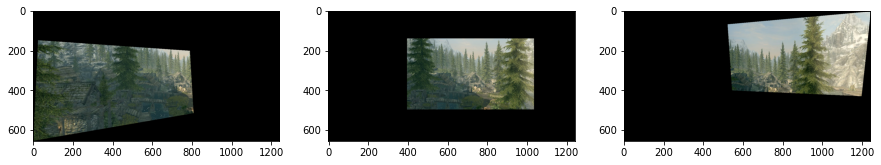

In [3]:
fig = plt.figure(figsize=(15, 12)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(cvtColor(img1, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 2) 
plt.imshow(cvtColor(img2, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 3) 
plt.imshow(cvtColor(img3, COLOR_BGR2RGB)) 

In [4]:
h, w = img1.shape[:2]
print(img1.shape)

(655, 1241, 3)


In [5]:
img1 = (img1.flatten()).astype(np.float32)
img2 = (img2.flatten()).astype(np.float32)
img3 = (img3.flatten()).astype(np.float32)
IMGS_f = [img1, img2, img3]

---

In [19]:
# index = j + i*w - 1
y,x = 1, 6
index = x + y*w 
index, index // w, index % w 

(1247, 1, 6)

## Init

In [7]:
C = np.array([0,1,2], dtype=np.uint8)

In [8]:
# Neighbours ind
N = np.full((h*w, 4), -1, dtype = np.int32)

for i in range(h):
    for j in range(w):
        
        index = j + i*w

        # left
        if j > 0:
            left_index = j - 1 + i*w
            N[index, 0] = left_index
        # right
        if j < w - 1:
            right_index = j + 1 + i*w
            N[index, 1] = right_index
         # up
        if i > 0:
            up_index = j + (i-1)*w
            N[index, 2] = up_index
        # down
        if i < h - 1:
            down_index = j + (i+1)*w
            N[index, 3] = down_index

In [9]:
N[1244]

array([1243, 1245,    3, 2485])

In [10]:
# Phi
phi = np.zeros((len(N), len(C)))

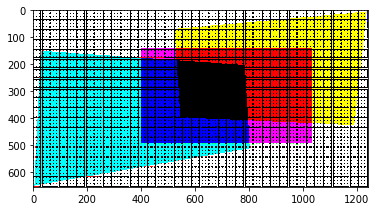

In [11]:
@njit
def init_q(IMGS, C, N):
    q = np.zeros((w*h, len(C)), dtype=np.float32)
    
    zero = np.zeros(3, dtype=np.uint8)
    for i in range(w*h):
            for c in C:

                y,x = i // w, i % w
                if (IMGS[c][y,x,:] == zero).all():
                    q[i, c] = np.inf
                else:
                    q[i, c] = 0   
    return q
                    
q = init_q(IMGS, C, N)
plt.imshow(q.reshape((h,w,3)))

In [12]:
@njit
def init_g(IMGS, C, N):
    
    g = np.zeros((w*h, 4, len(C), len(C)), dtype=np.float32)
    
    for i in range(w*h):
        #if i % 100000 == 0:print(i)
        y,x = i // w, i % w
        
        for n_ind, n in enumerate(N[i]):
            y_, x_ = n // w, n % w
            
            for c in C:
                for c_ in C:
                    g[i, n_ind, c, c_] = norm(IMGS[c][y,x,:] - IMGS[c][y_,x_,:]) + norm(IMGS[c_][y,x,:] - IMGS[c_][y_,x_,:])    
    return g

g = init_g(IMGS, C, N)

In [13]:
L = np.zeros((len(N), len(C)), dtype=np.float64)
R = np.zeros((len(N), len(C)), dtype=np.float64)
U = np.zeros((len(N), len(C)), dtype=np.float64)
D = np.zeros((len(N), len(C)), dtype=np.float64)

---

# Main

In [14]:
for i in reversed(range(len(N))):
    y,x = i // w, i % w + 1
    i_down = x + (y+1)*w - 1
    
    D

In [27]:
i = 3
y,x = i // w, i % w + 1
index = x + (y+1)*w - 1
y1,x1 = index // w, index % w + 1

(f'i: {i} | y,x: {y,x} | index: {index} | y1,x1: {y1,x1}')

'i: 3 | y,x: (0, 4) | index: 1244 | y1,x1: (1, 4)'

In [20]:
N[0]

array([  -1,    1,   -1, 1241])